## TODO
* Features:
    * Easy visualization of: case starts, concurrent case obligations
    * printouts/reports of parameters used to generate analyses
    * utils: determine if an event falls in an arbitrary time window; aggregate to show a weekly incidence (across days of week), vs 52 weeks/yr, 12 months/year; expected formats for activity events 
    * some clinical questions to be answered: mishaps during nights and wkends vs weekdays, per provider, or likelihood when activity (anesthesia demand) is high
* Code:
    * subclass of DataFrame for Staffing
        * standardize expected formats for records for staffing and processing for same
        * eventually be able to move this in to an ActivityDataset and make use of functionality there
    * subclass of DataFrame for AnesthesiaCases
        * standardize expected format for input of anesthesia cases (columns, allowed values)
        * help for data wrangling: parse dates/times, combine dates+times, inspect procedures, map to allowed ones, exclude disallowed ones
        * eventually be able to move this in to an ActivityDataset and make use of functionality there
        * determine concurrency (w an arbitrary time unit size, optionally grouped perhaps by resource?)
        * categorize activity (according to some kind of map or profile?)
        * fill in durations as a column, if start and end are provided
        * fill in end as a column, if start and duration are provided
        * on init, expects data (a DataFrame or collection that can be used to start one), and has kwargs to specify which column represents activity_start and activity_stop
    * subclass of DataFrame for AnesthesiaCaseEvents
        * eventually be able to move this in to an ActivityDataset and make use of functionality there
    * subclass of DataFrame for AnesthesiaCaseMedications
        * eventually be able to move this in to an ActivityDataset and make use of functionality there
* tests:
    * make an ActivityDataset from valid data collection
    * make an ActivityDataset from valid DataFrame
    * proceess concurrency from valid ActivityDataset

In [1]:
import sys
sys.path.append("/home/tj/PycharmProjects/pytiva")

import os
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm import tqdm

import pytiva

# TODO: case starts by arbitrary periodicity
# TODO: anesthesia resources occupied by arbitrary periodicity
wd = r'/home/tj/PycharmProjects/pytiva/tests/test_data'
filename = 'activity_test_data_full.csv'

In [3]:
df = pd.read_csv(os.path.join(wd, filename), parse_dates=['activity_start', 'activity_end'])
ds = pytiva.ActivityDataset(df)
df_cc = ds.concurrency_ts()
df_cc

100%|███████████████████████████████████████| 4010/4010 [05:23<00:00, 12.41it/s]


,concurrent_activity_count
timestamp,
2021-11-21 06:49:00,1.0
2021-11-21 06:50:00,2.0
2021-11-21 06:51:00,2.0
2021-11-21 06:52:00,2.0
2021-11-21 06:53:00,2.0
...,...
2022-08-11 17:09:00,1.0
2022-08-11 17:10:00,1.0
2022-08-11 17:11:00,1.0


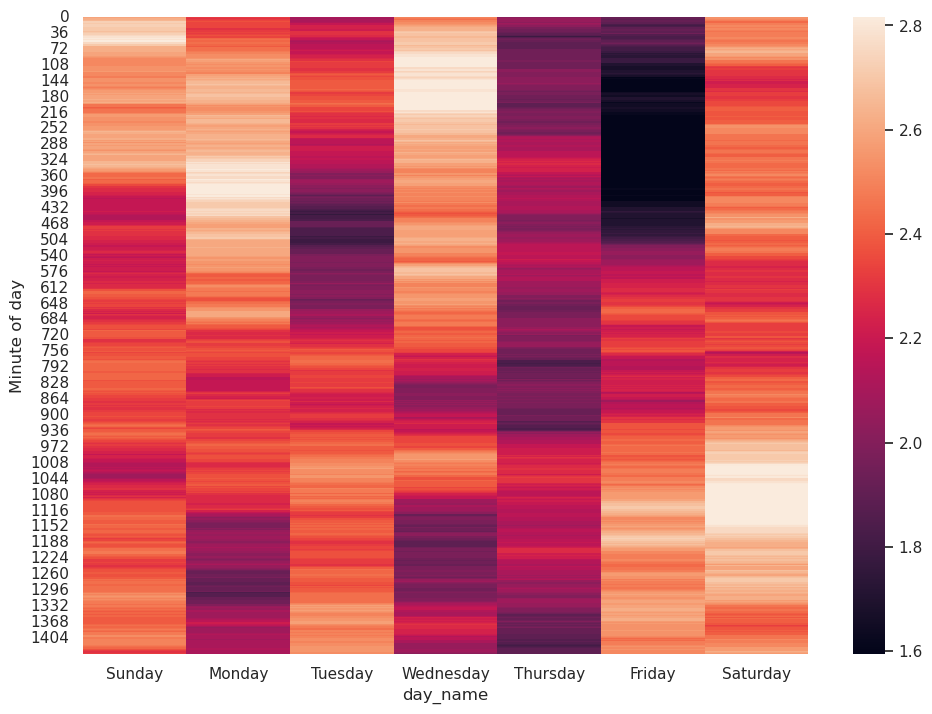

In [7]:
cc_wa = pytiva.activity.utils.concurrent_weekly_activity(df_cc)
graph = sn.heatmap(unstacked, robust=True)
plt.ylabel('Minute of day')
sn.set(rc={'figure.figsize':(11.7,8.27)})
plt.savefig(os.path.join(wd, 'test_concurrent_weekly_activity_graph.png'), format='png')